In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
# 注意！指定绘图风格后需要重新配置以显示中文
# sns.set_style('darkgrid',{'font.sans-serif':'Microsoft YaHei'}) 

## Scipy一维插值

In [2]:
# 生成已知的数据点集 (x,y)
np.random.seed(666)
x = np.linspace(0, 10, 20) # 生成已知数据点x
y = np.cos(x**2)+ x # 生成已知数据点y
xnew = np.linspace(0, 10, 500) # 设定需进行插值的数据点集xnew

In [14]:
from scipy.interpolate import interp1d
# 使用不同插值方法，由给定数据点集 (x,y) 求插值函数 fx
f1 = interp1d(x, y, kind="linear") # 线性插值
########################################
f2 = interp1d(x, y, kind="nearest") # 最近邻插值，向下取舍
f3 = interp1d(x, y, kind="nearest-up") # 最近邻插值，向上取舍
########################################
f4 = interp1d(x, y, kind="zero") # 零阶样条插值
f5 = interp1d(x, y, kind="slinear") # 一次样条插值
f6 = interp1d(x, y, kind="quadratic") # 二次样条插值
f7 = interp1d(x, y, kind="cubic") # 三次样条插值
########################################
f8 = interp1d(x, y, kind="previous")  # 前点插值
f9 = interp1d(x, y, kind="next") # 后点插值

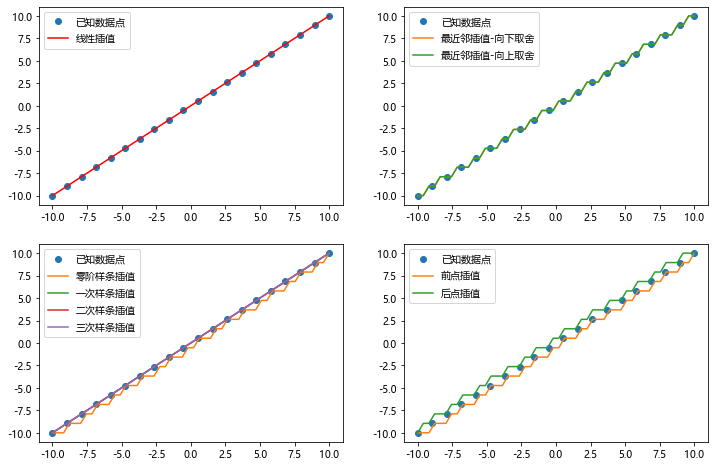

In [15]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,8))
ax1.plot(x,y,'o',label='已知数据点')
ax1.plot(xnew,f1(xnew),'r',label='线性插值')
ax1.legend()

ax2.plot(x,y,'o',label='已知数据点')
ax2.plot(xnew,f2(xnew),label='最近邻插值-向下取舍')EE
ax2.plot(xnew,f3(xnew),label='最近邻插值-向上取舍')
ax2.legend()

ax3.plot(x,y,'o',label='已知数据点')
ax3.plot(xnew,f4(xnew),label='零阶样条插值')
ax3.plot(xnew,f5(xnew),label='一次样条插值')
ax3.plot(xnew,f6(xnew),label='二次样条插值')
ax3.plot(xnew,f7(xnew),label='三次样条插值')
ax3.legend()

ax4.plot(x,y,'o',label='已知数据点')
ax4.plot(xnew,f8(xnew),label='前点插值')
ax4.plot(xnew,f9(xnew),label='后点插值')
ax4.legend()

## 多维插值方法

### Scipy简单多维插值

In [5]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

rng = np.random.default_rng() # 随机数生成器
points = rng.random((1000, 2)) # 生成1000个随机点(x,y)
values = func(points[:,0], points[:,1]) # 计算已知随机点的值, z

# 生成插值网格
xnew, ynew = np.linspace(0,1,200), np.linspace(0,1,200)
xnew_grid, ynew_grid = np.meshgrid(xnew, ynew)

In [6]:
from scipy.interpolate import griddata
# 使用不同插值方法，由已知数据(x,y,z)，计算插值网格的z值
xi = (xnew_grid, ynew_grid)
z1 = griddata(points, values, xi, method="nearest")  # 最近邻插值
z2 = griddata(points, values, xi, method="linear")  # 线性插值
z3 = griddata(points, values, xi, method="cubic")  # 三次样条插值

Text(0.5, 0.92, '三次样条插值')

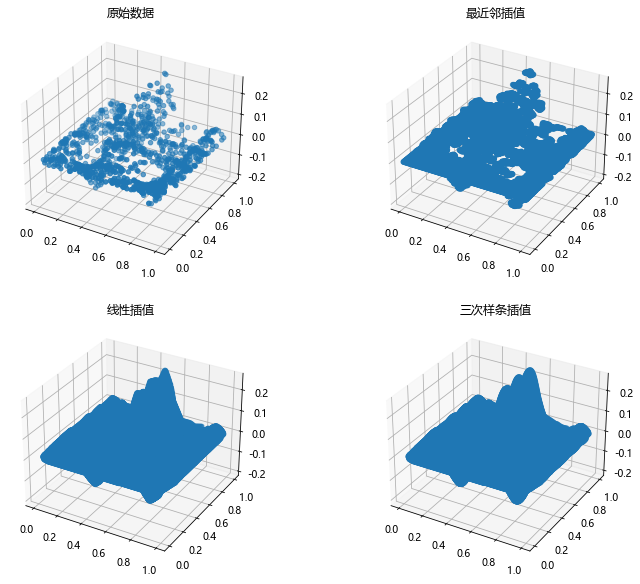

In [7]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,
                                             2,
                                             subplot_kw=dict(projection='3d'),
                                             figsize=(12, 10))
# 原始数据
ax1.scatter3D(points[:, 0], points[:, 1], values)
ax1.set_title('原始数据')
# 最近邻插值
ax2.scatter3D(xnew_grid, ynew_grid, z1)
ax2.set_title('最近邻插值')
# 线性插值
ax3.scatter3D(xnew_grid, ynew_grid, z2)
ax3.set_title('线性插值')
# 三次样条插值
ax4.scatter3D(xnew_grid, ynew_grid, z3)
ax4.set_title('三次样条插值')

## 反距离权重插值（IDW）
- IDW是一种精确的全局插值法，即全部样点都参与某一待估点的Z值的估算；其中每个采样对插值结果的影响随距离增加而减弱，因此距目标点近的样点赋予的权重较大。
- IDW的适用于呈均匀分布且密集程度足以反映局部差异的样点数据集；

In [8]:
def IDW(xnewgrid,ynewgrid,x, y, z, b=2):
    """
    :param xnew: 网格化的插值点x
    :param ynew: 网格化的插值点y
    :param x: 已知数据点x
    :param y: 已知数据点y
    :param z: 已知数据点z
    :return: 插值结果
    """
    xnewgrid_, ynewgrid_ = xnewgrid.ravel(), ynewgrid.ravel()
    znew = []
    # 计算每个插值点的插值结果
    for i in range(len(xnewgrid_)):   
        # 遍历计算所有离散数据点与该插值点的距离
        d = np.sqrt((xnewgrid_[i]-x)**2 + (ynewgrid_[i]-y)**2) # 计算两点间的距离
        if 0 in d:
            znew.append(z[np.where(d == 0)[0][0]]) # 如果插值点为离散数据点中的一个，则直接返回该点的值
        else:
            distance = 1 / (d**b) # 计算距离权重函数, b为距离倒数的幂，常数，一般b越大，内插结果越平滑
            distance_sum = np.sum(distance)
            distance_weight = distance / distance_sum
            znew.append(np.sum(distance_weight * z))
    znew = np.array(znew)
    znew = znew.reshape(xnewgrid.shape)
    return znew

In [9]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

x = np.linspace(-10, 10, 20)  # 生成已知数据点x
y = np.linspace(-10, 10, 20)  # 生成已知数据点y
z = func(x, y) # 生成已知数据点z

# 生成插值网格
xnew = np.linspace(-10, 10, 50)
ynew = np.linspace(-10, 10, 50)
xnew_grid, ynew_grid = np.meshgrid(xnew, ynew)

Text(0.5, 0.92, 'IDW插值')

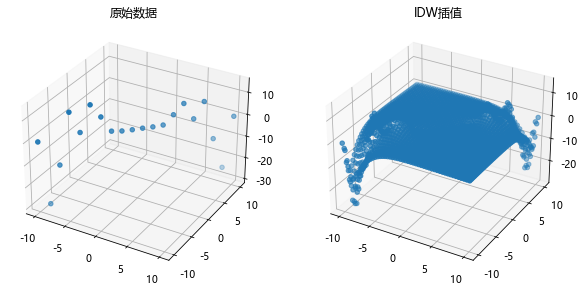

In [10]:
znew = IDW(xnew_grid,ynew_grid,x, y, z, b=2)
fig, [ax1, ax2] = plt.subplots(1,2,subplot_kw=dict(projection='3d'),figsize=(10, 8))
# 原始数据
ax1.scatter3D(x,y,z)
ax1.set_title('原始数据')
# 最近邻插值
ax2.scatter3D(xnew_grid, ynew_grid, znew)
ax2.set_title('IDW插值')

## 克里金插值(Kriging)

In [11]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

x = np.linspace(-10, 10, 20)  # 生成已知数据点x
y = np.linspace(-10, 10, 20)  # 生成已知数据点y
z = func(x, y) # 生成已知数据点z

# 生成插值网格
xnew = np.linspace(-10, 10, 50)
ynew = np.linspace(-10, 10, 50)
xnew_grid, ynew_grid = np.meshgrid(xnew, ynew)

In [12]:
from pykrige.ok import OrdinaryKriging
# 创建克里金网格和方差网格
OK = OrdinaryKriging(
    x, # 已知数据点x
    y, # 已知数据点y
    z, # 已知数据点z
    variogram_model="linear",
)
znew, ss = OK.execute("grid", xnew, ynew) # 计算插值网格z和方差网格ss

Text(0.5, 0.92, '克里金插值')

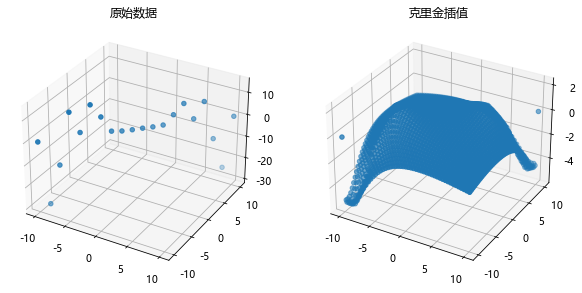

In [13]:
fig, [ax1, ax2] = plt.subplots(1,2,subplot_kw=dict(projection='3d'),figsize=(10, 8))
# 原始数据
ax1.scatter3D(x,y,z)
ax1.set_title('原始数据')
# 最近邻插值
ax2.scatter3D(xnew_grid, ynew_grid, znew)
ax2.set_title('克里金插值')